Detecting faces...
128  faces were detected in the training dataset
Extracting HOG features from faces
Detecting faces...
Extracting HOG features from faces
Training Random Forest Classifier


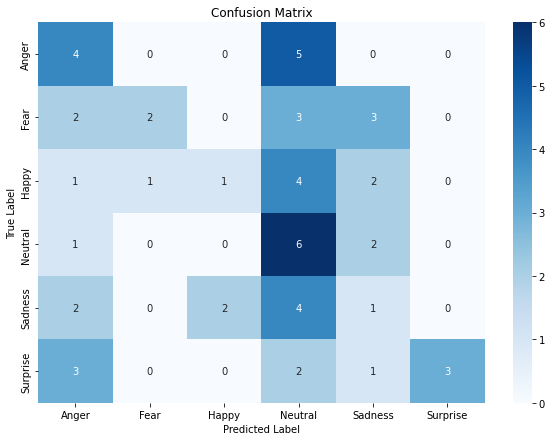

Class 0
TP :  4
FP :  9
FN :  5
TN :  37
Accuracy :  0.7454545454545455
Precision :  0.3076923076923077
Recall :  0.4444444444444444
F1-Score :  0.3636363636363637


Class 1
TP :  2
FP :  1
FN :  8
TN :  44
Accuracy :  0.8363636363636363
Precision :  0.6666666666666666
Recall :  0.2
F1-Score :  0.30769230769230765


Class 2
TP :  1
FP :  2
FN :  8
TN :  44
Accuracy :  0.8181818181818182
Precision :  0.3333333333333333
Recall :  0.1111111111111111
F1-Score :  0.16666666666666666


Class 3
TP :  6
FP :  18
FN :  3
TN :  28
Accuracy :  0.6181818181818182
Precision :  0.25
Recall :  0.6666666666666666
F1-Score :  0.36363636363636365


Class 4
TP :  1
FP :  8
FN :  8
TN :  38
Accuracy :  0.7090909090909091
Precision :  0.1111111111111111
Recall :  0.1111111111111111
F1-Score :  0.1111111111111111


Class 5
TP :  3
FP :  0
FN :  6
TN :  46
Accuracy :  0.8909090909090909
Precision :  1.0
Recall :  0.3333333333333333
F1-Score :  0.5




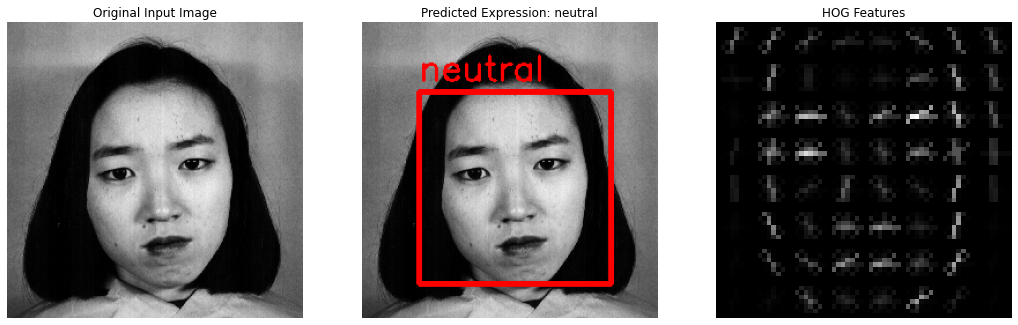

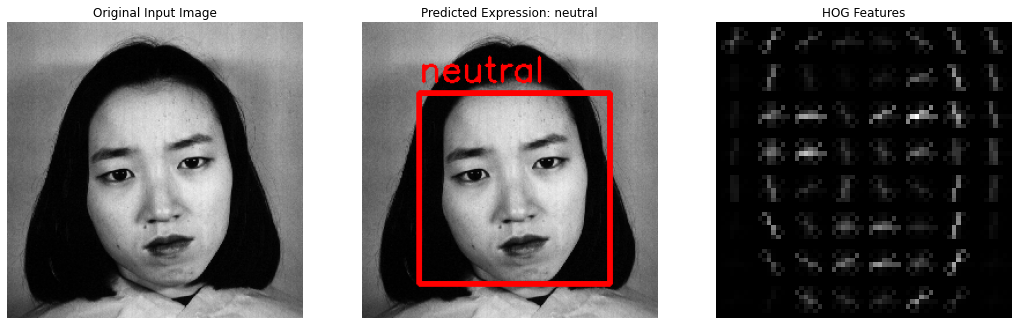

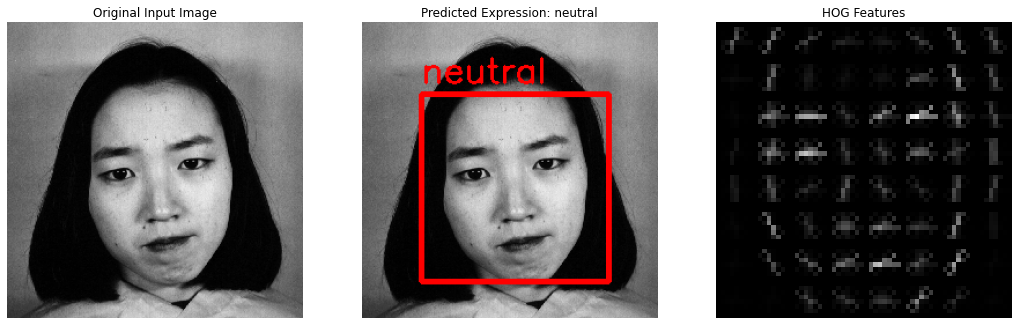

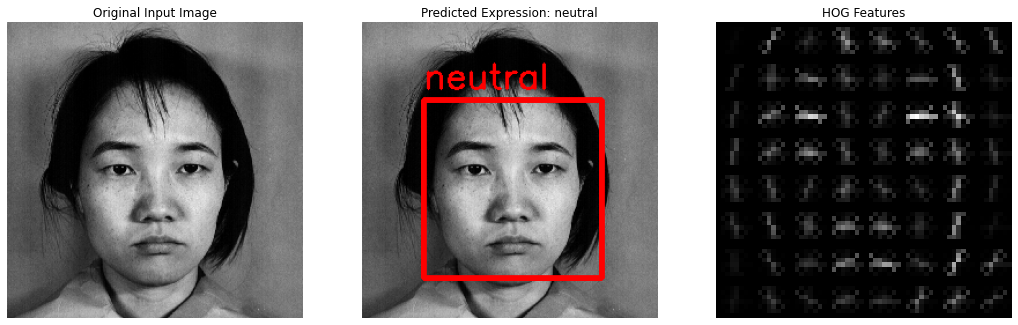

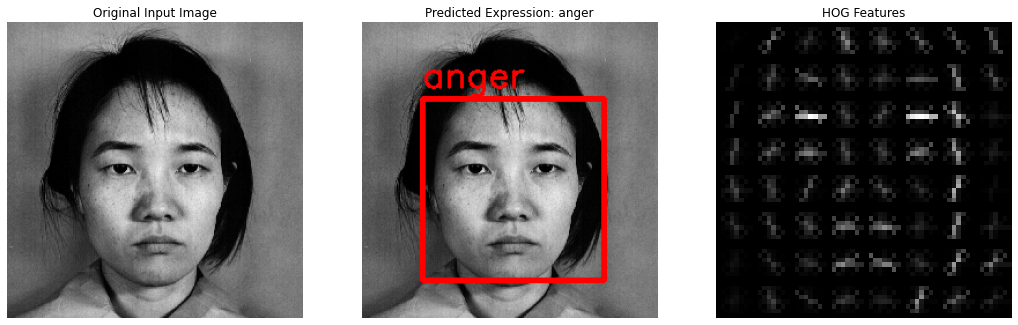

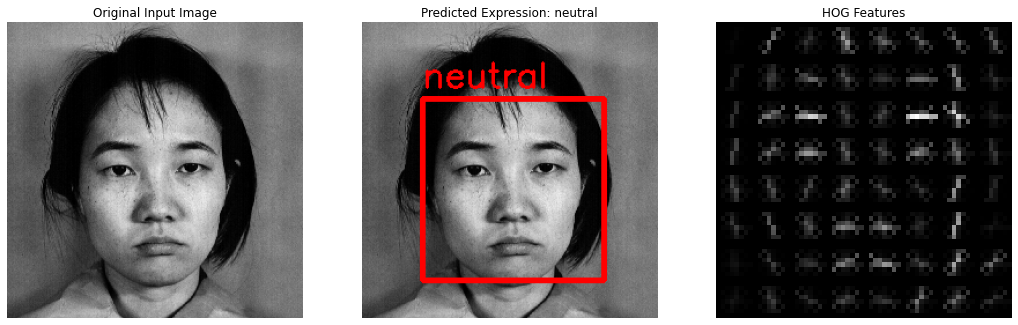

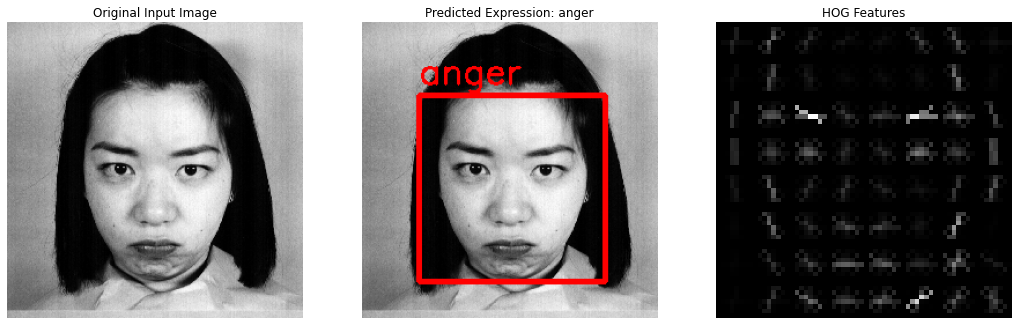

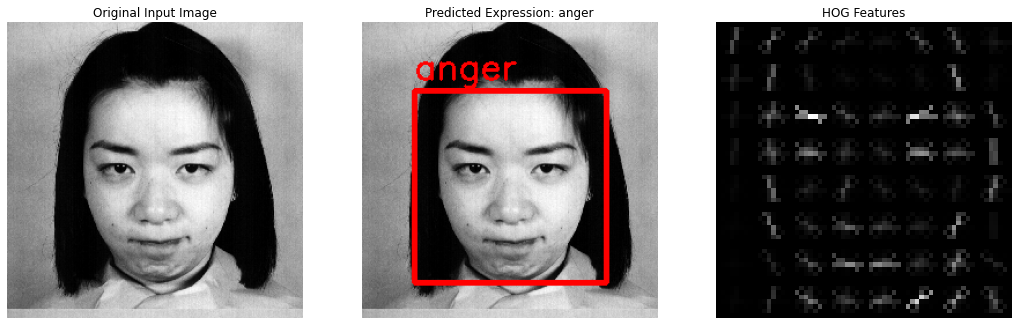

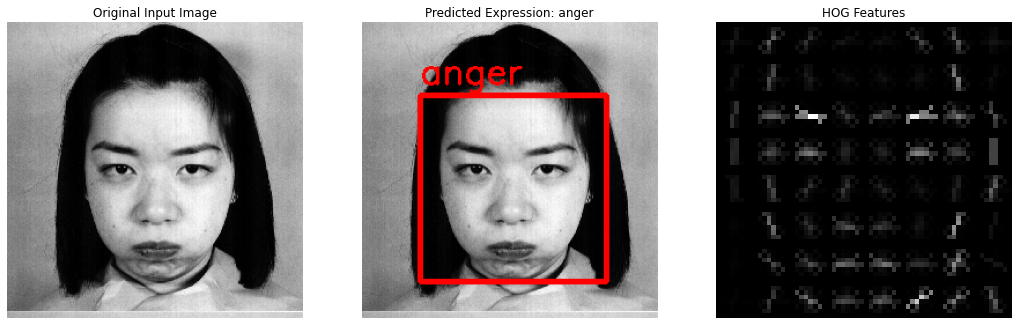

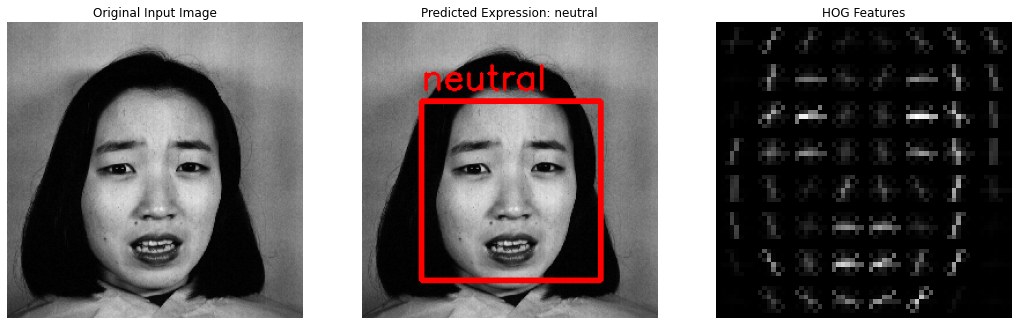

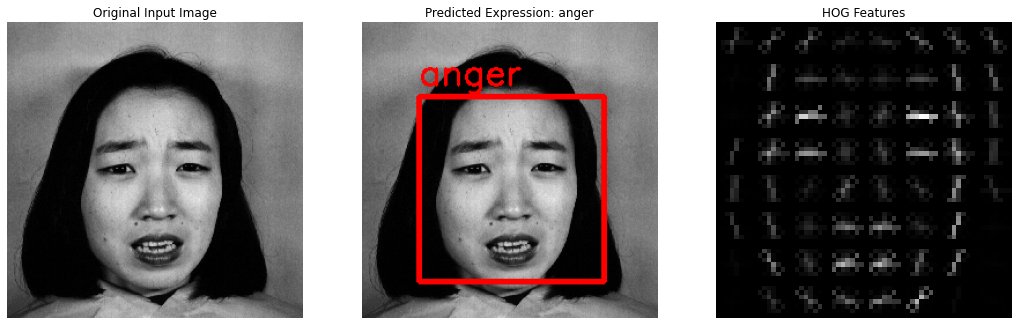

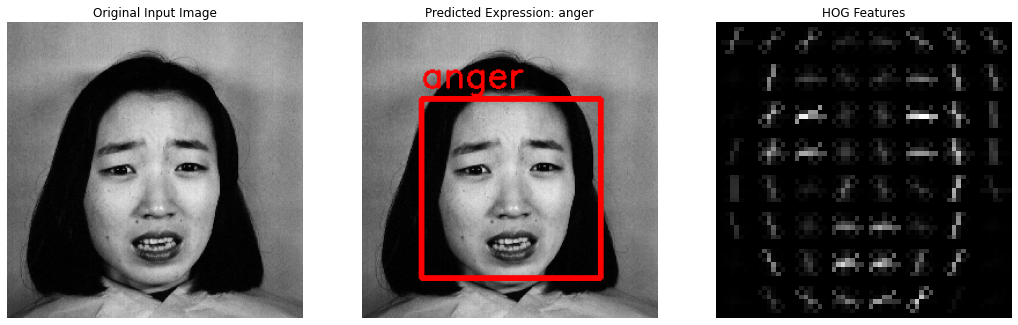

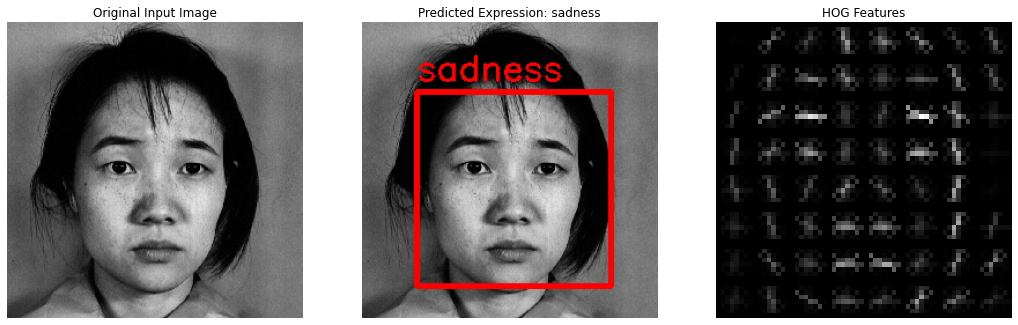

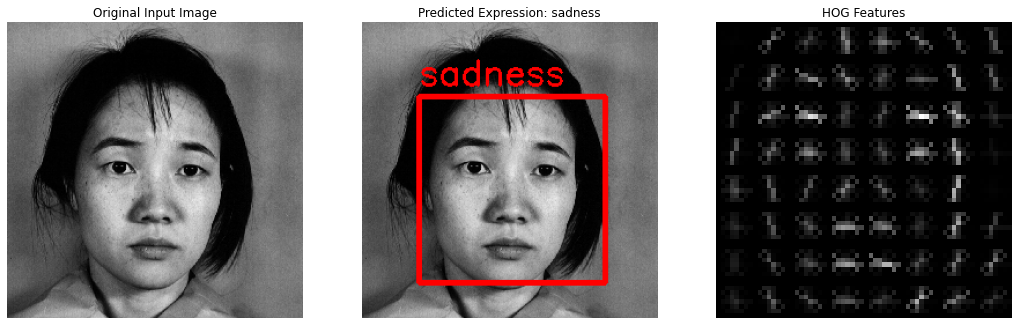

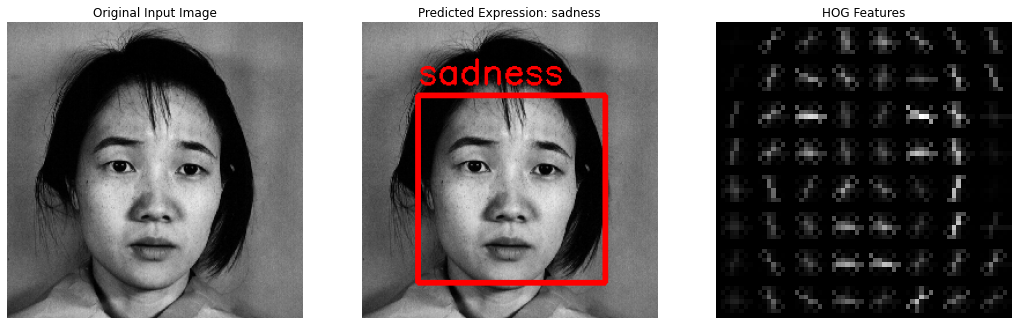

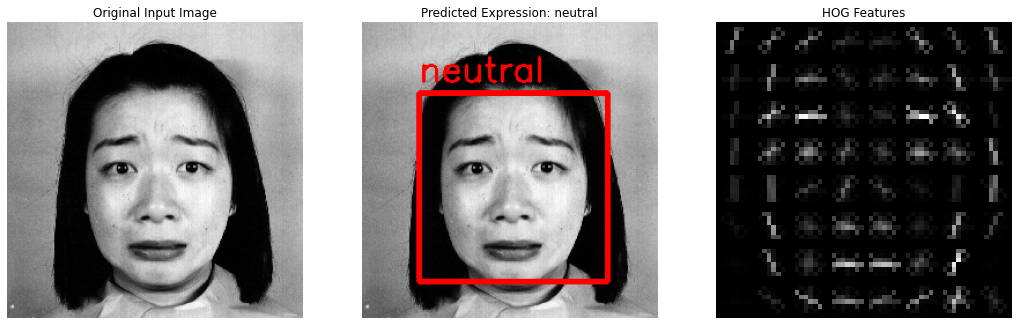

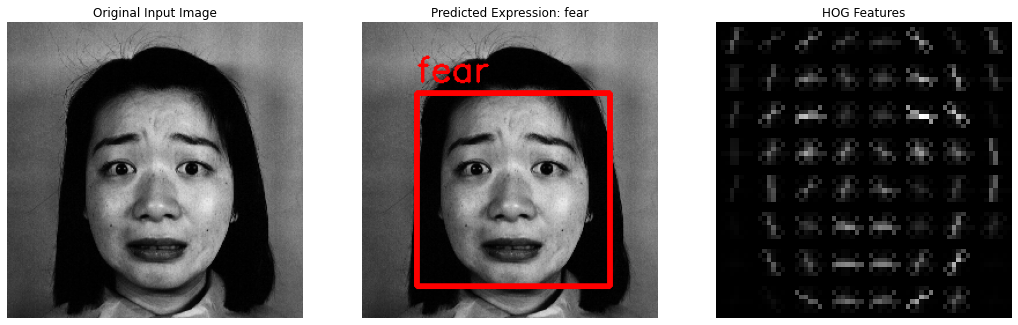

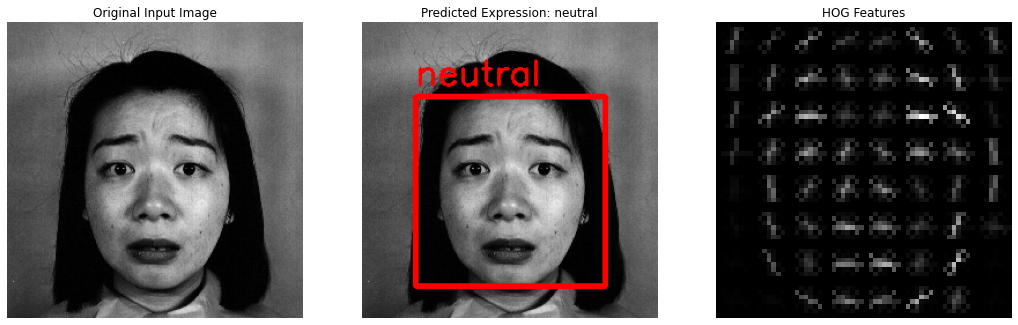

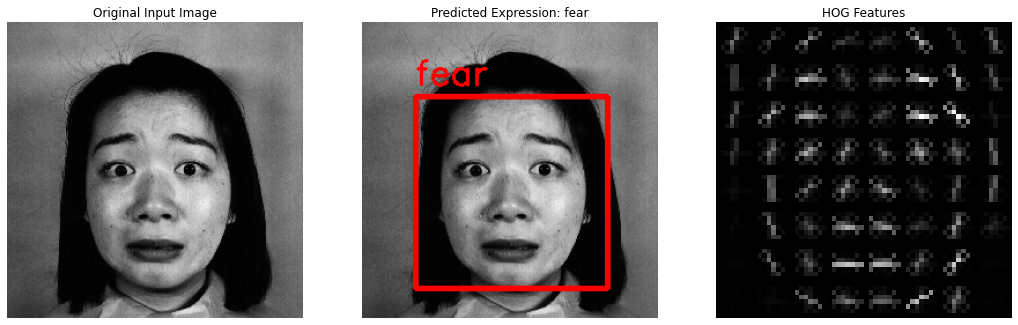

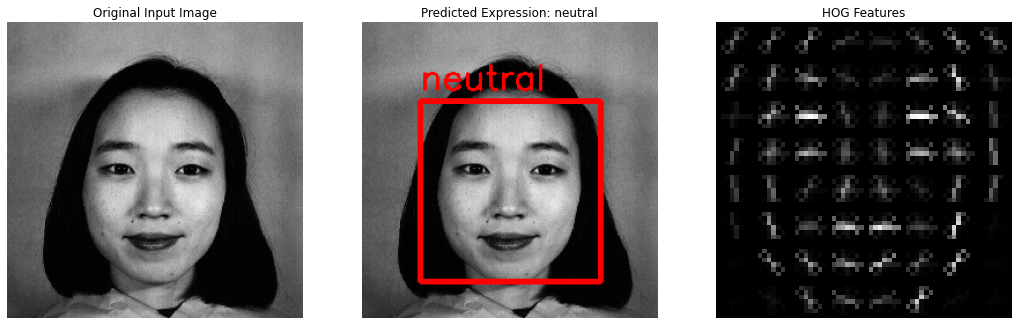

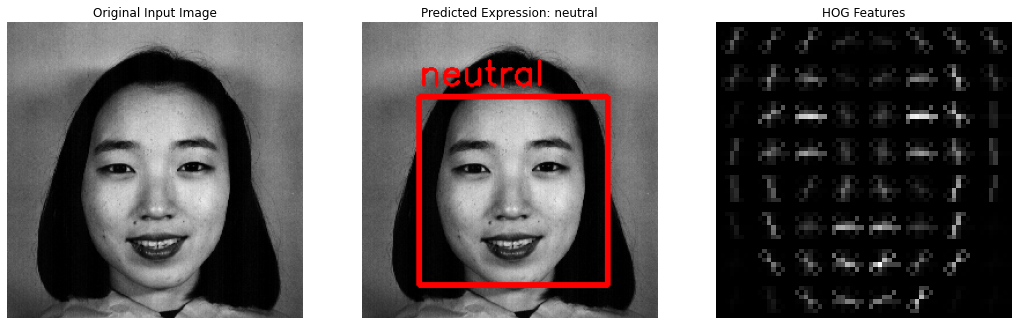

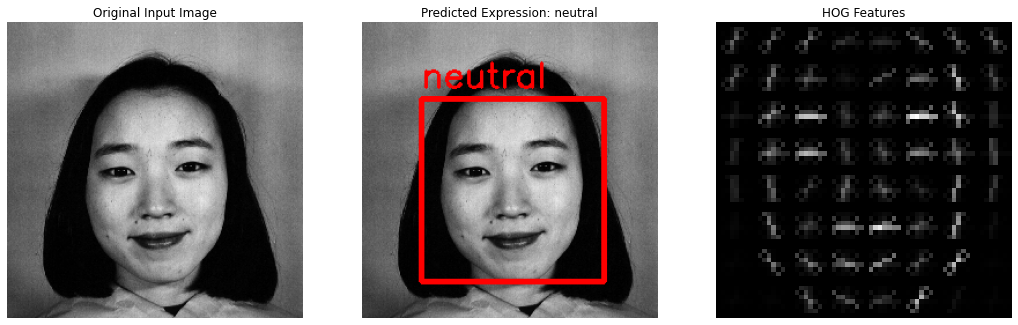

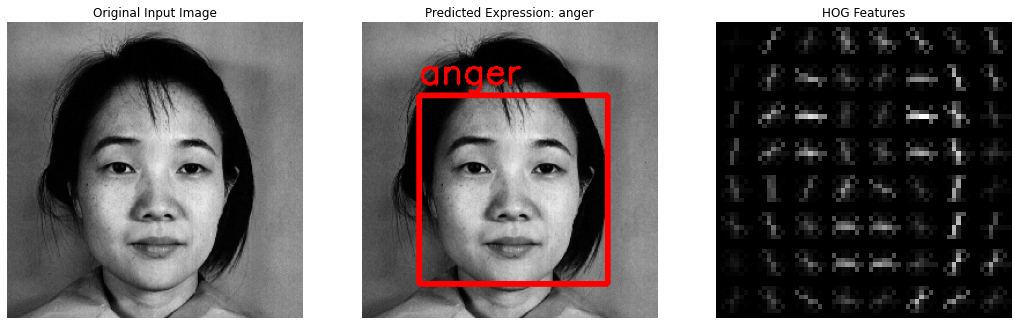

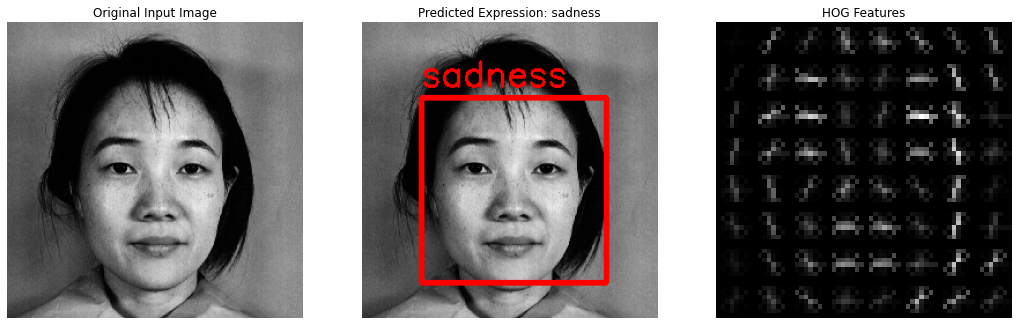

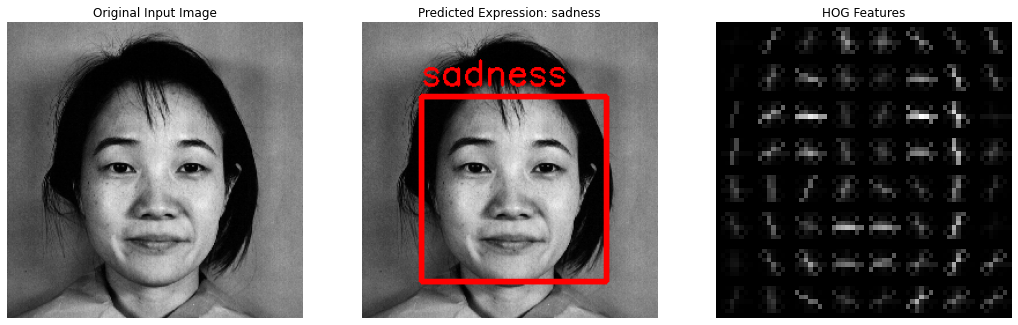

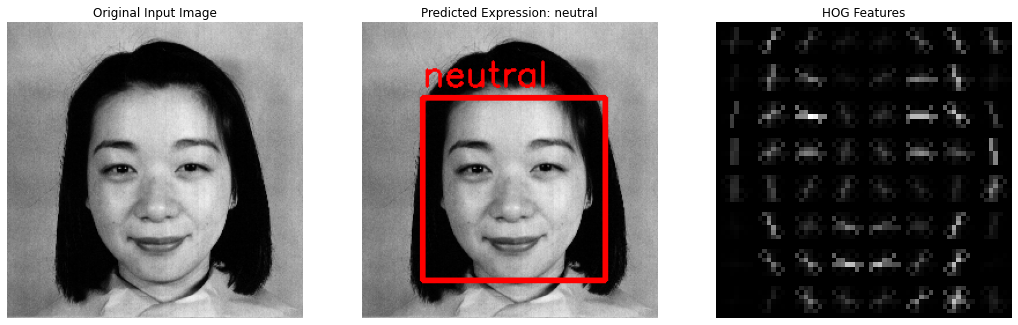

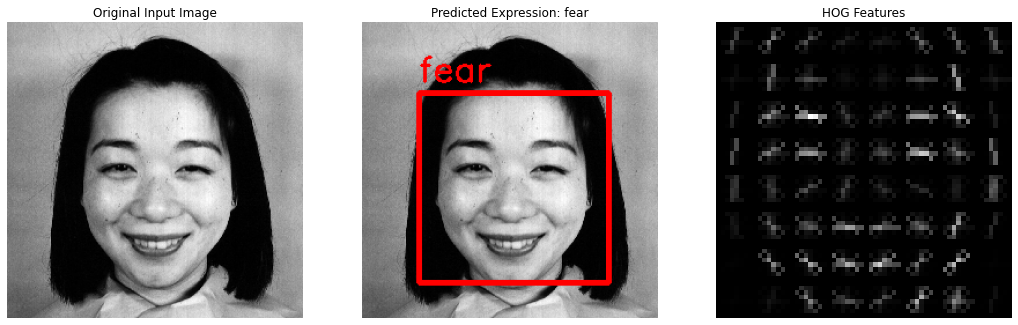

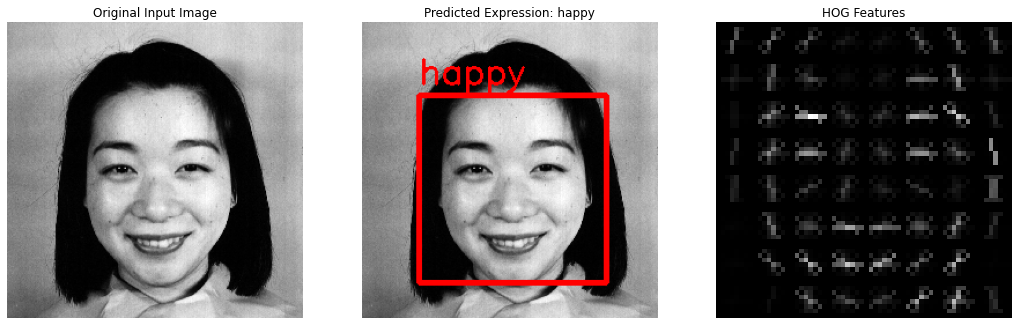

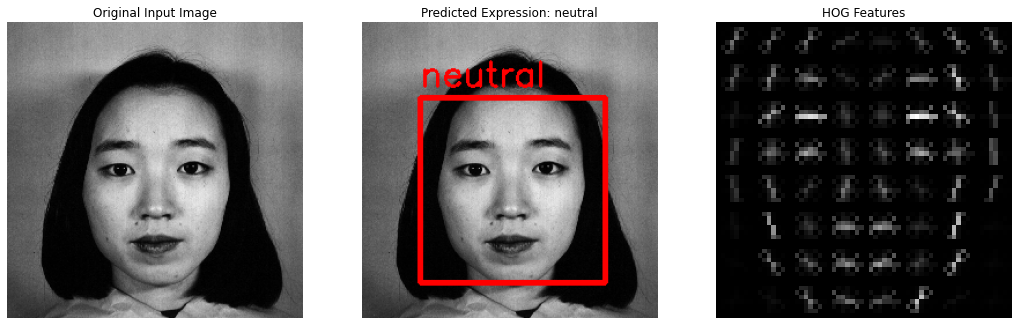

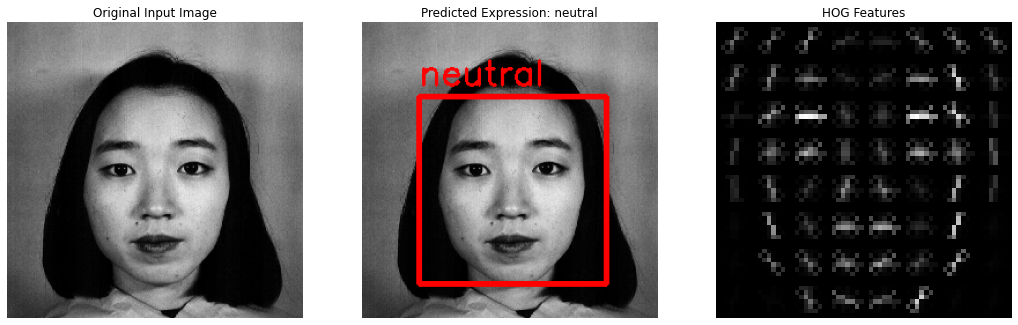

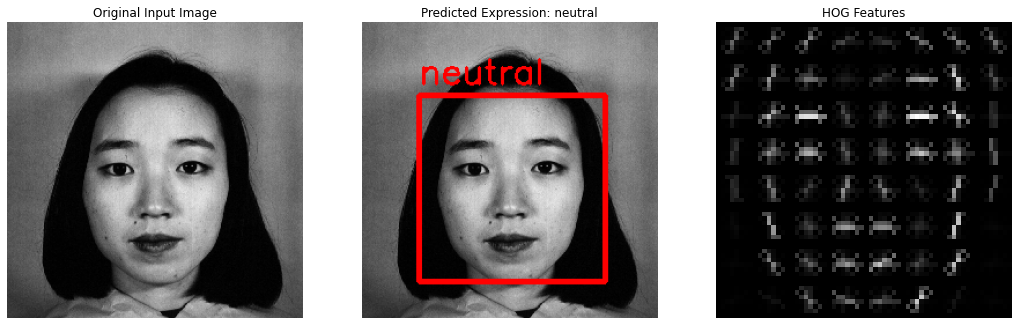

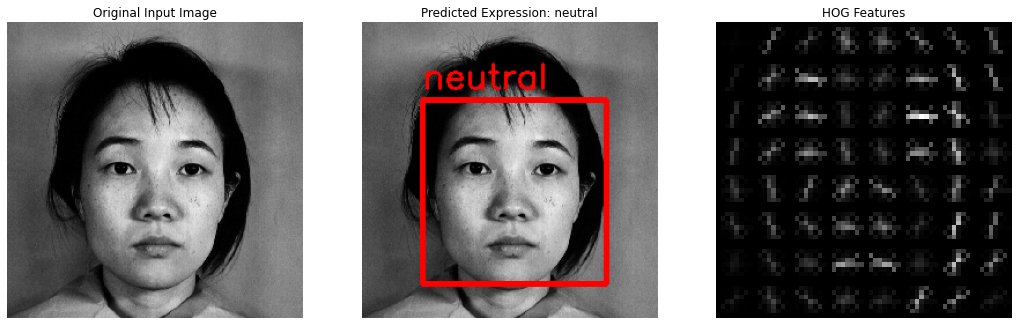

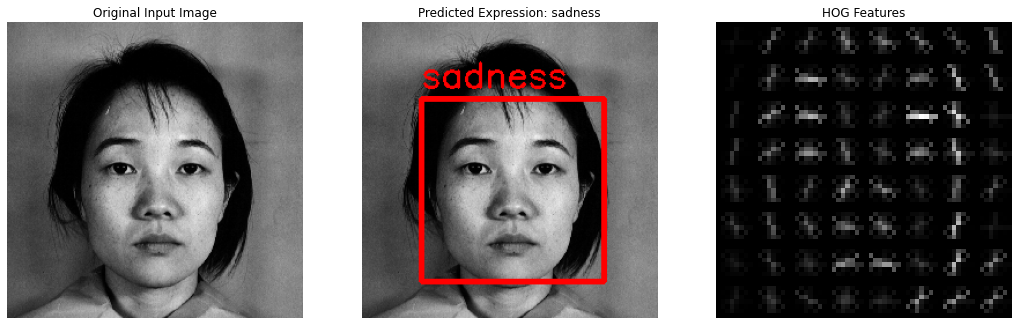

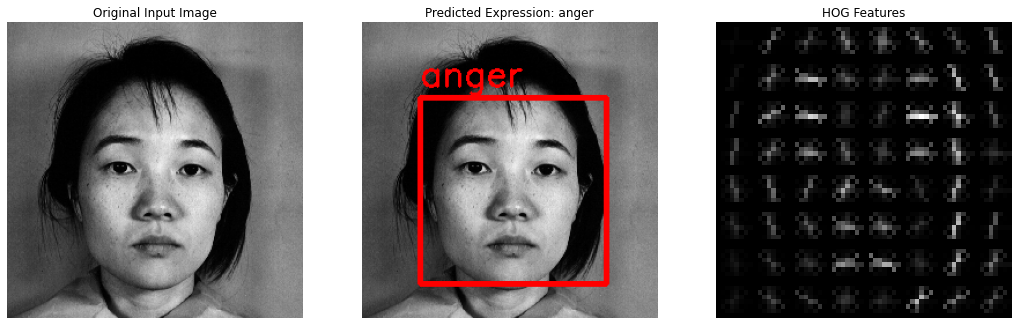

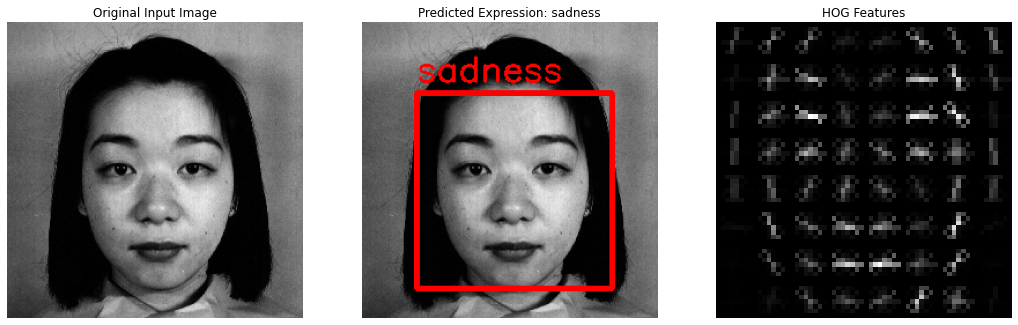

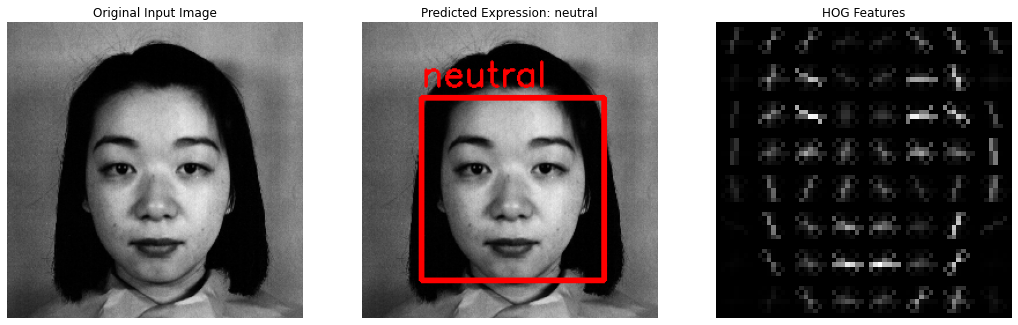

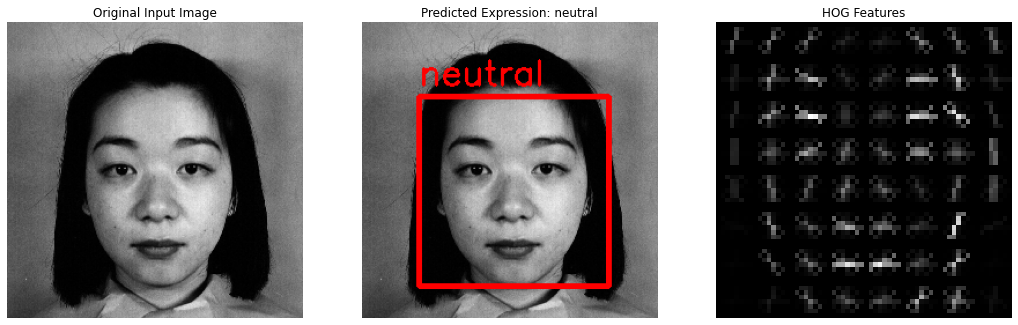

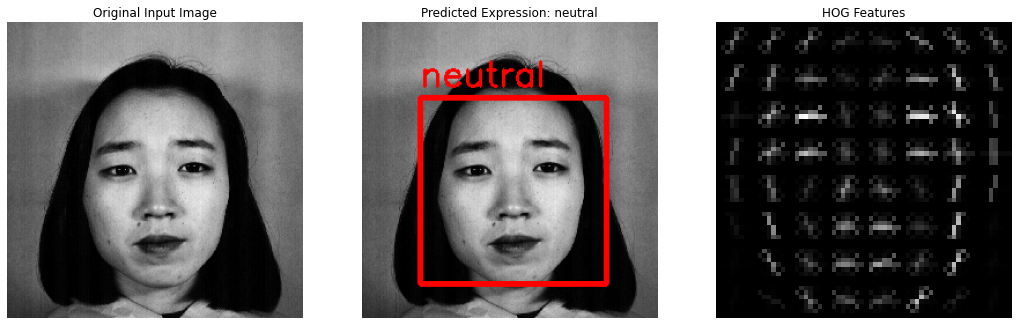

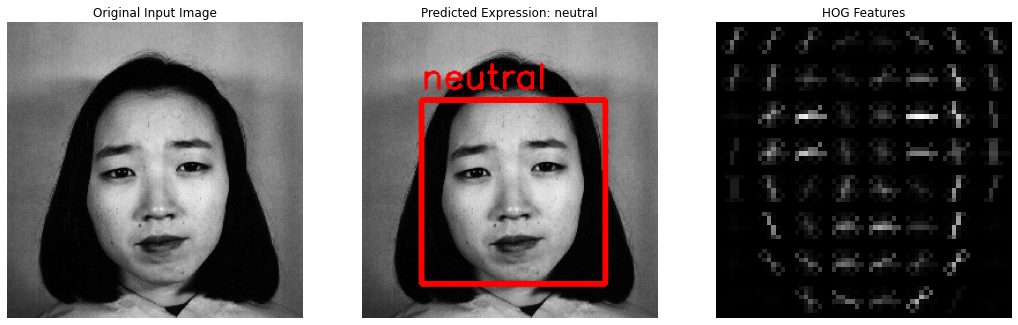

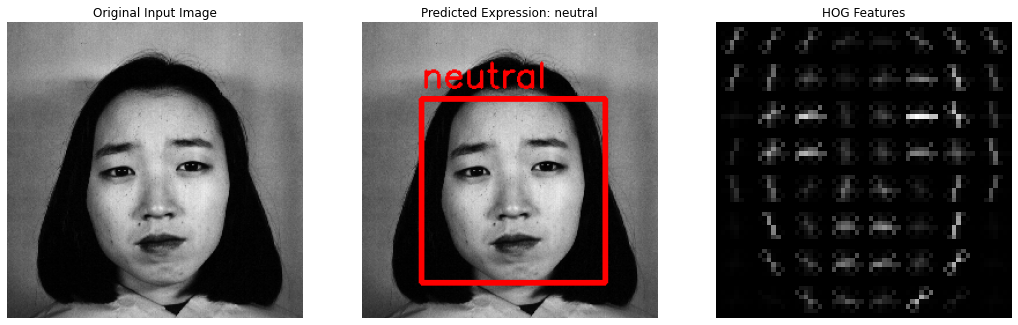

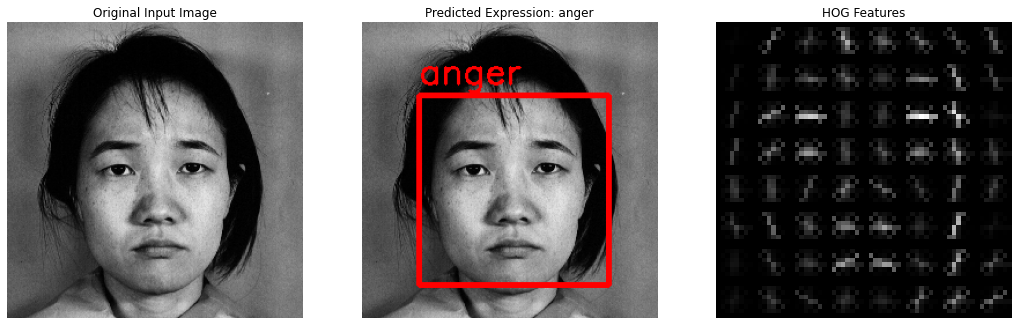

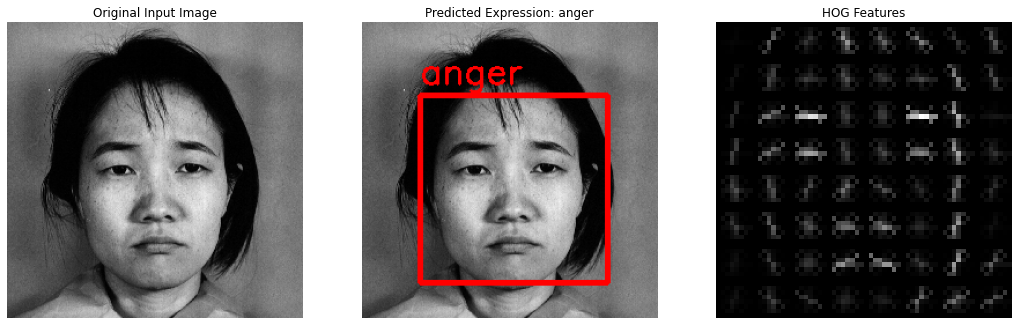

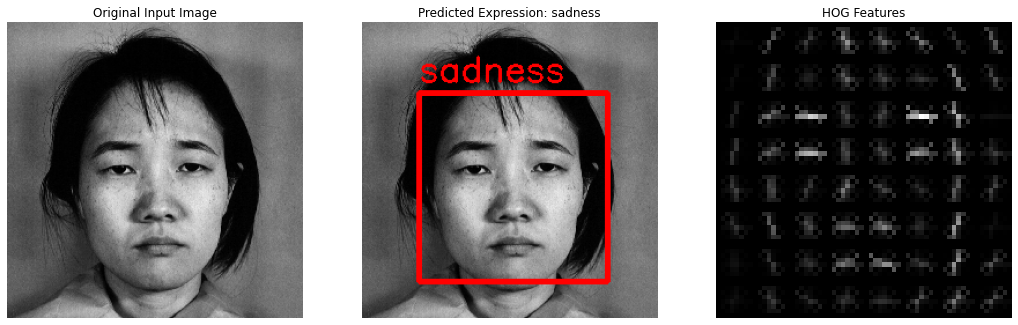

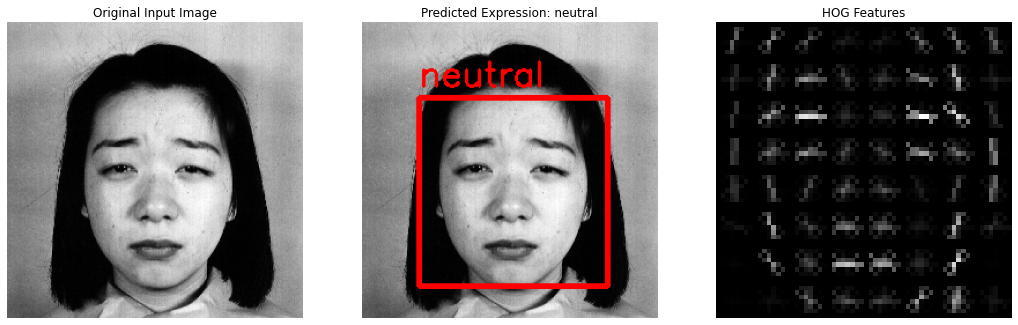

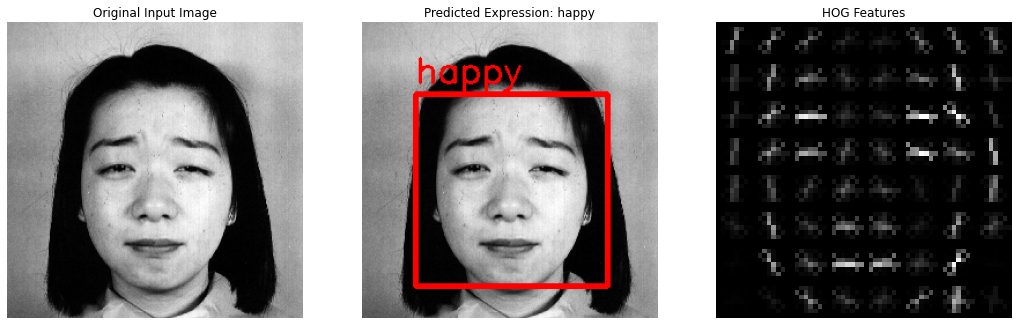

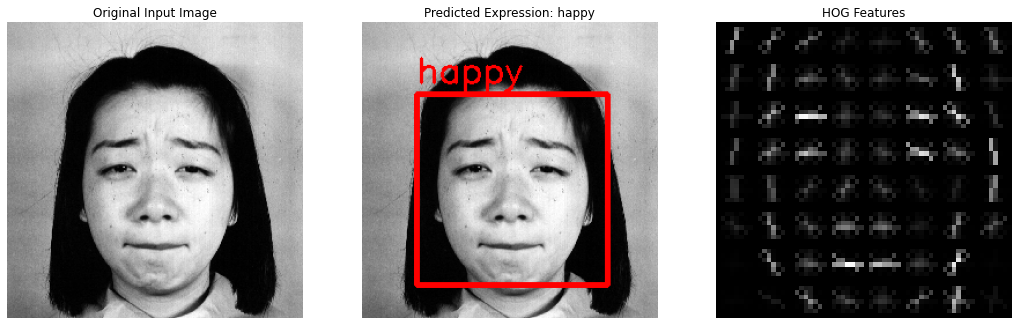

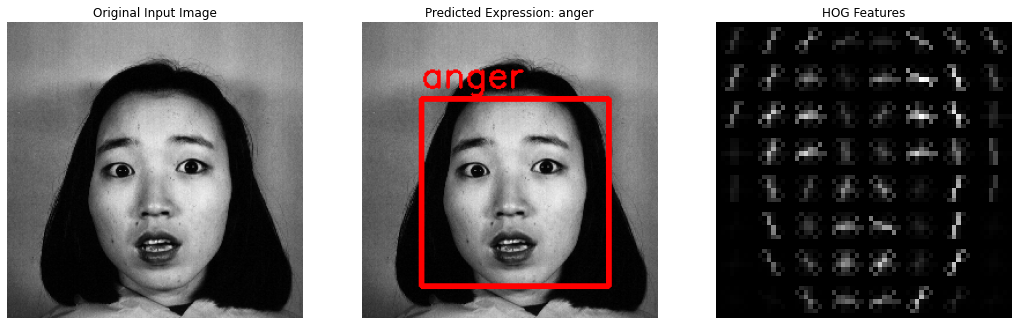

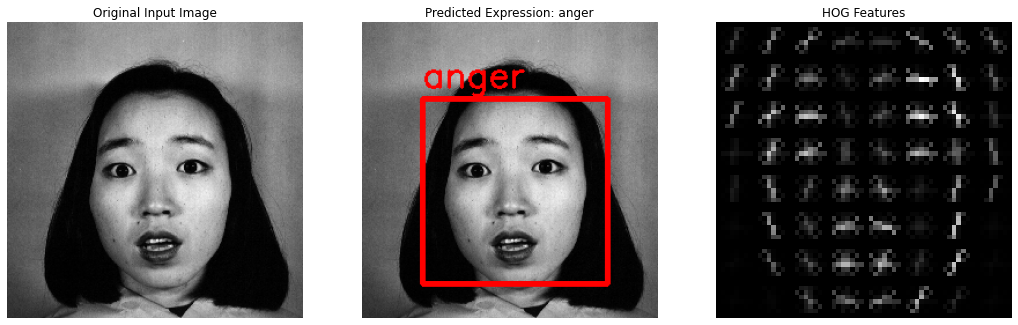

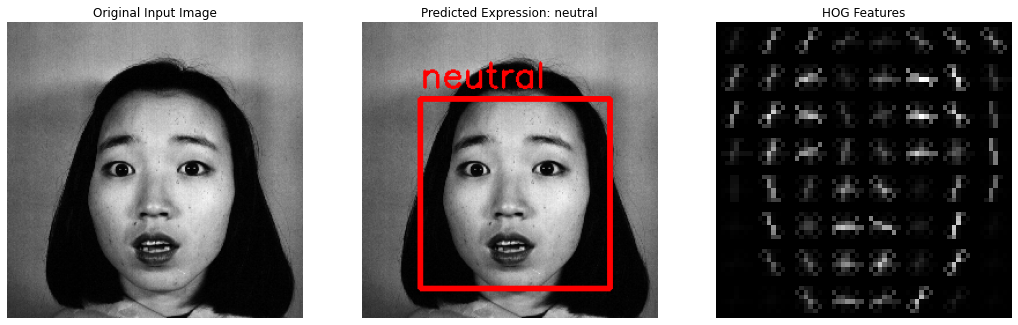

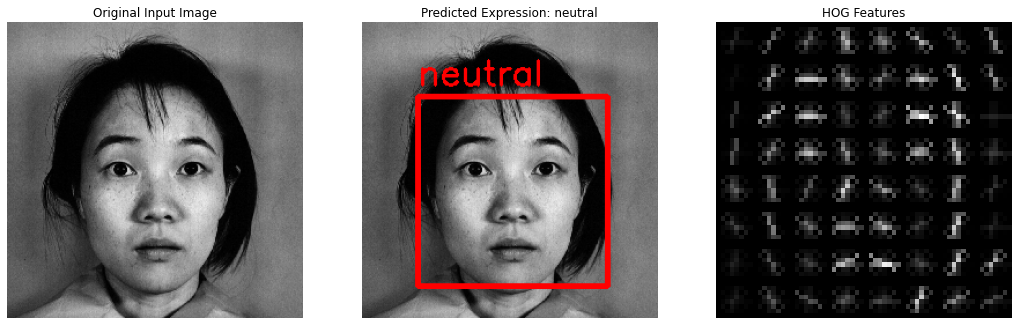

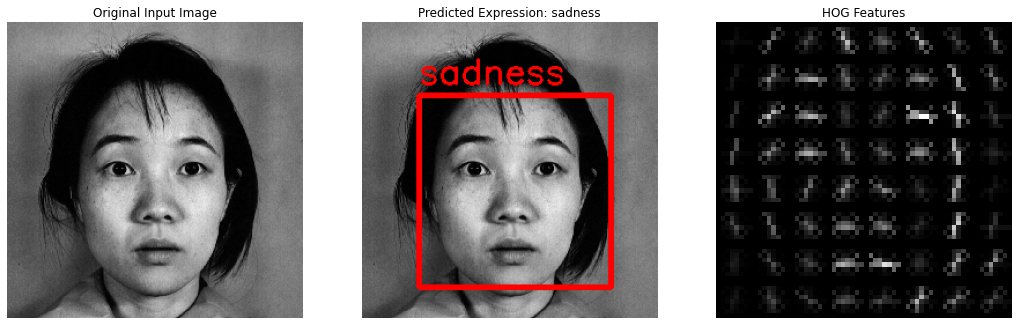

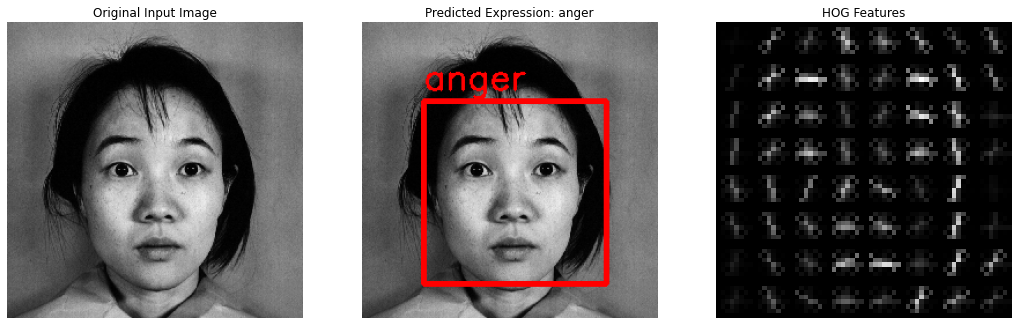

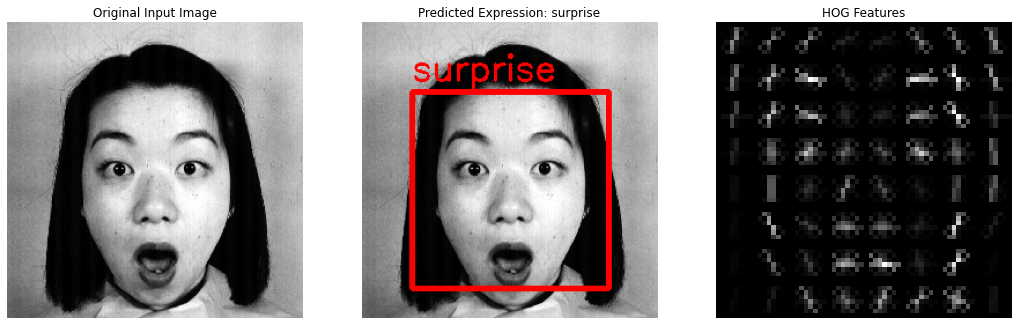

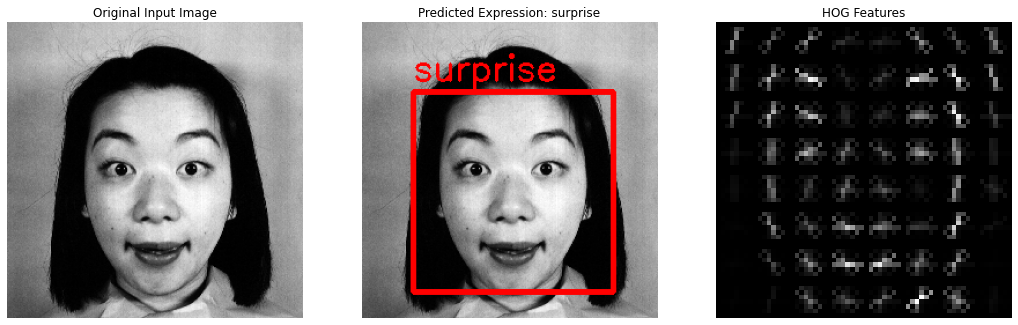

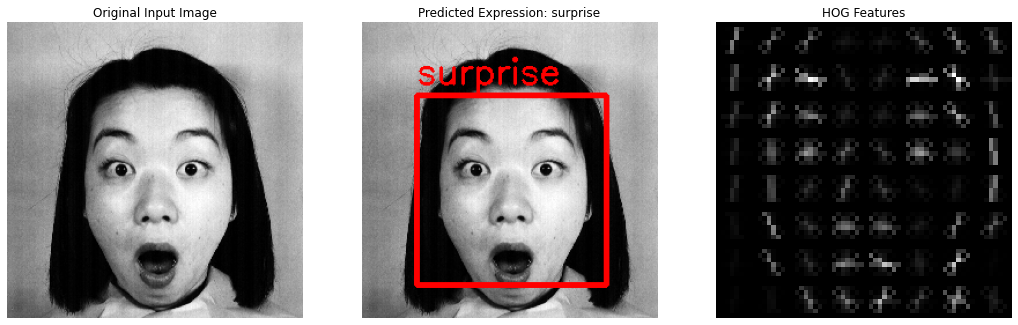

In [14]:
# Importing openCV library for Haar cascade
import cv2

# Importing numpy to return array of features
import numpy as np

# Importing OS commands to loop through folder
import os

# Importing pyplot to plot the faces with bounding boxes
import matplotlib.pyplot as plt

# Importing seaborn to render Confusion Matrix
import seaborn as sns

# Importing Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Importing HOG capability
from skimage.feature import hog

# Importing accuracy_score and confusion_matrix 
from sklearn.metrics import accuracy_score, confusion_matrix


# Loading the Haar Cascade for face detection. The XML file contains a pre trained classifier to decide whether the picture contains a face
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# This method uses the openCV Haar Cascade to detect faces in the provided images
def detect_faces(images_folder_path):

  print("Detecting faces...")
    
  # Initializing images and labels
  images = []
  labels = []

  # Looping through each folder in the images folder path
  for label in os.listdir(images_folder_path):

    label_path = os.path.join(images_folder_path, label)

    # Looping through the directory searching for images
    for img_file in os.listdir(label_path):

        # Getting the path for the image to be processed
        img_path = os.path.join(label_path, img_file)

        # imread loads the image from the path, with the IMREAD_GRAYSCALE flag assigning the intenstity values based on the original colour pixels. Bright
        # areas have higher values and darker areas have lower values
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # If imread reads a file that isn't an image, an empty matrix is returned. 
        if img is not None:

          # This method call will use the face cascade to try and detect a face in the supplied image
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            
          if len(faces) == 0:
            
            print("ERROR : No face detected in " , img_path)

          # This code loops through a list of rectangles which represent detected faces in the images
          # x is the x co-ordinate of the top left corner of the rectangle
          # y is the y co-ordinate of the top left corner of the rectangle
          # w is the width of the rectangle
          # h is the height of the rectangle
          for (x, y, w, h) in faces:
            
            # The face region is extracted from the image
            face_region = img[y:y+h, x:x+w]

            # The face is added to the list of images to be fed in for feature extraction
            images.append(face_region)

            # Adding the label of the image to the list of labels
            labels.append(label)
        
        else:
            
            print("ERROR : No image detected")
            
  # Returning the list of images and their associated labels to the calling program.
  return images, labels

# This method extracts the HOG features from a face image which can then be fed into the random forest for classification
def extract_hog_features_from_face(face_images):

  print("Extracting HOG features from faces")
  hog_features = []

  for face_img in face_images:

      # Resizing the image to 64x64 pixels. This ensures there is a standardized input size for the HOG feature extraction
      face_img = cv2.resize(face_img, (64,64))

      # This method call extracts HOG features from the supplied image
      hog_feat = hog(face_img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),  block_norm='L2-Hys')

      # The HOG features returned are added to an array of HOG features
      hog_features.append(hog_feat)

  # Returning the array of HOG features to the calling program
  return np.array(hog_features)


# This method is used to predict an emotion and then output the result
def predict_emotions(images_folder_path, model, face_features):
    
      for label in os.listdir(images_folder_path):

        label_path = os.path.join(images_folder_path, label)

        if os.path.isdir(label_path):

          # Looping through the directory searching for images
          for img_file in os.listdir(label_path):
                
            # Getting the path for the image to be processed
            image_path = os.path.join(label_path, img_file)

            # Read the image in grayscale for face detection
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error: Could not load image from {image_path}")
                return

            # Detect face in the image
            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            if len(faces) == 0:
                print("No face detected in the image.")
                return

            # Process the first detected face (for simplicity)
            x, y, w, h = faces[0]
            face_region = img[y:y + h, x:x + w]

            # Resizing the face and extracting HOG features with visualization
            face_region_resized = cv2.resize(face_region, (64, 64))
            hog_features, hog_image = hog(
                face_region_resized,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=True
            )
            hog_features = np.array(hog_features).reshape(1, -1) 

            # This code will predict the expression using the trained model
            predicted_expression = model.predict(hog_features)[0]

            # Loading the original image in color for visualization
            img_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            # Draw a rectangle around the detected face
            img_with_box = img_rgb.copy()
            cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Red rectangle

            # Display the predicted label above the rectangle
            cv2.putText(img_with_box, predicted_expression, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Display three subplots: prediction, face with bounding box, and HOG features
            plt.figure(figsize=(18, 6))

            # Display the original image
            plt.subplot(1, 3, 1)
            plt.imshow(img_rgb)
            plt.title("Original Input Image")
            plt.axis('off')

            # Display the face with bounding box
            plt.subplot(1, 3, 2)
            plt.imshow(img_with_box)
            plt.title(f"Predicted Expression: {predicted_expression}")
            plt.axis('off')

            # Display the HOG features
            plt.subplot(1, 3, 3)
            plt.imshow(hog_image, cmap='gray')
            plt.title("HOG Features")
            plt.axis('off')

            plt.show()


# Setting the paths for the trainiong and testing folders
training_data_folder_path = ('./Training_Data_JAFFE')
testing_data_folder_path = ('./Testing_Data_JAFFE')

# Loading and detecting faces for the training data
x_Train_Faces, y_Train = detect_faces(training_data_folder_path)

if len(x_Train_Faces) == 0:
    print("ERROR : No faces detected in the training dataset.")
else:
    print(len(x_Train_Faces), " faces were detected in the training dataset")
    
# Extracting HOG features for the training data
x_Train_Features = extract_hog_features_from_face(x_Train_Faces)

# Loading and detecting faces for the testing data
x_Test_Faces, y_Test = detect_faces(testing_data_folder_path)

if len(x_Test_Faces) == 0:
    print("ERROR : No faces detected in the test dataset.")

# Extracting HOG features for the testing data
x_Test_Features = extract_hog_features_from_face(x_Test_Faces)

print("Training Random Forest Classifier")

# Initalizing the Random Forest Decision Tree Classifier. The maximum depth of decision trees in the classifier has been set to 10 to avoid overfitting where
# the model is too closely trained to predict specific sets of data, making it unreliable on test data
tree_Classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

# Training the classifier on the provided training data
tree_Classifier.fit(x_Train_Features, y_Train)

# Predicting emotions on the testing data
y_Prediction = tree_Classifier.predict(x_Test_Features)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_Test, y_Prediction)

# Generating confusion matrix, giving further insight into model accuracy
confusion_Matrix = confusion_matrix(y_Test, y_Prediction)

# Getting the number of classes to go through (should be 6)
num_classes = confusion_Matrix.shape[0]

# Define the class labels
class_labels = ['Anger', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_Matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Loops through all six classes and extracts TP, FP, FN and TN
for class_index in range(num_classes):
    
    tp = confusion_Matrix[class_index, class_index]  # True positives
    fp = confusion_Matrix[:, class_index].sum() - tp  # False positives
    fn = confusion_Matrix[class_index, :].sum() - tp  # False negatives
    tn = confusion_Matrix.sum() - (tp + fp + fn)  # True negatives
    
    # Outputting metrics
    print(f"Class {class_index}")
    print("TP : ", tp)
    print("FP : ", fp)
    print("FN : ", fn)
    print("TN : ", tn)
    print("Accuracy : ", (tp+tn)/(tp+tn+fp+fn))
    precision = tp/(tp+fp)
    print("Precision : ", precision)
    recall = tp/(tp+fn)
    print("Recall : ", recall)
    print("F1-Score : ", (2*precision*recall) / (precision+recall))
    print("\n")
    

# This method call will carry out the testing 
predict_emotions(testing_data_folder_path, tree_Classifier, x_Test_Features)
